# Efficient Multimodality

In [1]:
!pip install requests python-dotenv pandas pillow --upgrade mistralai
from pprint import pprint
from IPython.display import Image, display
from urllib.parse import urlparse, urljoin
import base64
from io import BytesIO
from dotenv import load_dotenv
from PIL import Image as PILImage
import os 
from mistralai import Mistral
import json
import pandas as pd
import requests


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


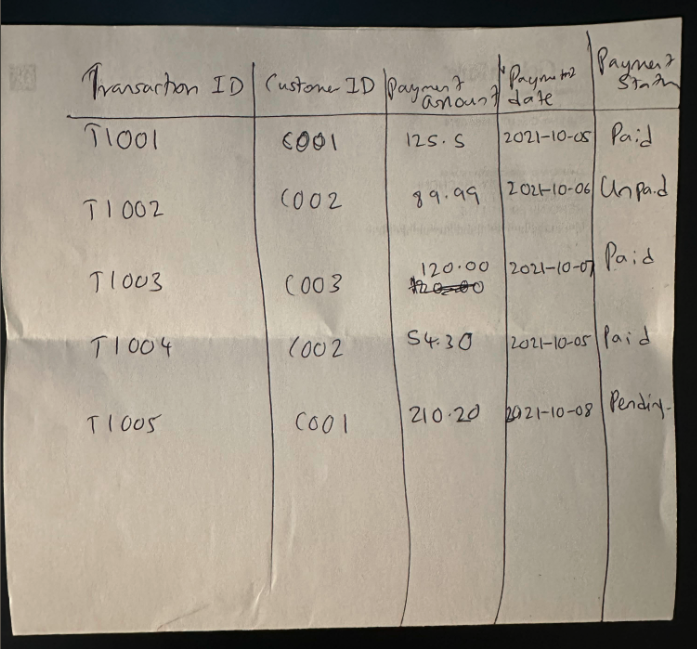

In [2]:
# Path to your image
image_path = "./table.png"
display(Image(filename=image_path))

In [22]:
import base64
import os
from mistralai import Mistral

def encode_image(image_path):
    """Encode the image to base64."""
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    except FileNotFoundError:
        print(f"Error: The file {image_path} was not found.")
        return None
    except Exception as e:  # Added general exception handling
        print(f"Error: {e}")
        return None



# Getting the base64 string
base64_image = encode_image(image_path)

load_dotenv()
# Retrieve the API key from environment variables
api_key = os.getenv("MISTRAL_KEY")

# Specify model
model = "pixtral-12b-2409"

# Initialize the Mistral client
client = Mistral(api_key=api_key)

# Define the messages for the chat
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": "Please extract the text from this image and output as a json object."
            },
            {
                "type": "image_url",
                "image_url": f"data:image/jpeg;base64,{base64_image}" 
            }
        ]
    }
]

# Get the chat response
chat_response = client.chat.complete(
    model=model,
    messages=messages,
    temperature=0.0,
    response_format = {
          "type": "json_object",
      }
)

# Print the content of the response
print(chat_response.choices[0].message.content)

{
  "transactions": [
    {
      "transaction_id": "T1001",
      "customer_id": "C001",
      "payment_amount": "125.5",
      "payment_date": "2021-10-05",
      "payment_status": "Paid"
    },
    {
      "transaction_id": "T1002",
      "customer_id": "C002",
      "payment_amount": "89.99",
      "payment_date": "2021-10-06",
      "payment_status": "Unpaid"
    },
    {
      "transaction_id": "T1003",
      "customer_id": "C003",
      "payment_amount": "120.00",
      "payment_date": "2021-10-07",
      "payment_status": "Paid"
    },
    {
      "transaction_id": "T1004",
      "customer_id": "C002",
      "payment_amount": "54.30",
      "payment_date": "2021-10-08",
      "payment_status": "Paid"
    },
    {
      "transaction_id": "T1005",
      "customer_id": "C001",
      "payment_amount": "210.20",
      "payment_date": "2021-10-08",
      "payment_status": "Pending"
    }
  ]
}


In [23]:
import json
import pandas as pd
from typing import Union

def json_to_dataframe(json_data: Union[str, dict], key: str = None) -> pd.DataFrame:
    # If json_data is a string, parse it into a dictionary
    if isinstance(json_data, str):
        json_data = json.loads(json_data)
    
    # If a key is provided, extract the list of records from the JSON object
    if key is not None:
        data = json_data[key]
    else:
        data = json_data
    
    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

df = json_to_dataframe(chat_response.choices[0].message.content, key='transactions')
df

,transaction_id,customer_id,payment_amount,payment_date,payment_status
0,T1001,C001,125.5,2021-10-05,Paid
1,T1002,C002,89.99,2021-10-06,Unpaid
2,T1003,C003,120.00,2021-10-07,Paid
3,T1004,C002,54.30,2021-10-08,Paid
4,T1005,C001,210.20,2021-10-08,Pending


# Function Calling

Function calling allows Mistral models to connect to external tools. By integrating Mistral models with external tools such as user defined functions or APIs, users can easily build applications catering to specific use cases and practical problems. In this guide, for instance, we wrote two functions for tracking payment status and payment date. We can use these two tools to provide answers for payment-related queries.

At a glance, there are four steps with function calling:

- User: specify tools and query
- Model: Generate function arguments if applicable
- User: Execute function to obtain tool results
- Model: Generate final answer

In this guide, we will walk through a simple example to demonstrate how function calling works with Mistral models in these four steps.

Before we get started, let’s assume we have a dataframe consisting of payment transactions. When users ask questions about this dataframe, they can use certain tools to answer questions about this data. This is just an example to emulate an external database that the LLM cannot directly access.

## Step 1. User: specify tools and query

### Tools

Users can define all the necessary tools for their use cases.

- In many cases, we might have multiple tools at our disposal. For example, let’s consider we have two functions as our two tools: `retrieve_payment_status` and `retrieve_payment_date` to retrieve payment status and payment date given transaction ID.

In [24]:
def retrieve_payment_status(df: df, transaction_id: str) -> str:
    if transaction_id in df.transaction_id.values:
        return json.dumps({'status': df[df.transaction_id == transaction_id].payment_status.item()})
    return json.dumps({'error': 'transaction id not found.'})

def retrieve_payment_date(df: df, transaction_id: str) -> str:
    if transaction_id in df.transaction_id.values:
        return json.dumps({'date': df[df.transaction_id == transaction_id].payment_date.item()})
    return json.dumps({'error': 'transaction id not found.'})

- In order for Mistral models to understand the functions, we need to outline the function specifications with a JSON schema. Specifically, we need to describe the type, function name, function description, function parameters, and the required parameter for the function. Since we have two functions here, let’s list two function specifications in a list.

In [25]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "retrieve_payment_status",
            "description": "Get payment status of a transaction",
            "parameters": {
                "type": "object",
                "properties": {
                    "transaction_id": {
                        "type": "string",
                        "description": "The transaction id.",
                    }
                },
                "required": ["transaction_id"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "retrieve_payment_date",
            "description": "Get payment date of a transaction",
            "parameters": {
                "type": "object",
                "properties": {
                    "transaction_id": {
                        "type": "string",
                        "description": "The transaction id.",
                    }
                },
                "required": ["transaction_id"],
            },
        },
    }
]


- Then we organize the two functions into a dictionary where keys represent the function name, and values are the function with the df defined. This allows us to call each function based on its function name.

In [26]:
import functools

names_to_functions = {
  'retrieve_payment_status': functools.partial(retrieve_payment_status, df=df),
  'retrieve_payment_date': functools.partial(retrieve_payment_date, df=df)
}

### User query

Suppose a user asks the following question: “What’s the status of my transaction?” A standalone LLM would not be able to answer this question, as it needs to query the business logic backend to access the necessary data. But what if we have an exact tool we can use to answer this question? We could potentially provide an answer!

In [27]:
messages = [{"role": "user", "content": "What's the status of my transaction T1001?"}]

## Step 2. Model: Generate function arguments

How do Mistral models know about these functions and know which function to use? We provide both the user query and the tools specifications to Mistral models. The goal in this step is not for the Mistral model to run the function directly. It’s to 1) determine the appropriate function to use , 2) identify if there is any essential information missing for a function, and 3) generate necessary arguments for the chosen function.

In [28]:
model = "pixtral-12b-2409"

client = Mistral(api_key=api_key)
response = client.chat.complete(
    model = model,
    messages = messages,
    tools = tools,
    tool_choice = "any",
)
response

ChatCompletionResponse(id='84b5fa7dfb13454d82c4b103a1192ffc', object='chat.completion', model='pixtral-12b-2409', usage=UsageInfo(prompt_tokens=155, completion_tokens=26, total_tokens=181), created=1730348248, choices=[ChatCompletionChoice(index=0, message=AssistantMessage(content='', tool_calls=[ToolCall(function=FunctionCall(name='retrieve_payment_status', arguments='{"transaction_id": "T1001"}'), id='rUFHcLGpq', type='function')], prefix=False, role='assistant'), finish_reason='tool_calls')])

In [29]:
messages.append(response.choices[0].message)

In [30]:
messages

[{'role': 'user', 'content': "What's the status of my transaction T1001?"},
 AssistantMessage(content='', tool_calls=[ToolCall(function=FunctionCall(name='retrieve_payment_status', arguments='{"transaction_id": "T1001"}'), id='rUFHcLGpq', type='function')], prefix=False, role='assistant')]

## Step 3. User: Execute function to obtain tool results

How do we execute the function? Currently, it is the user’s responsibility to execute these functions and the function execution lies on the user side. In the future, we may introduce some helpful functions that can be executed server-side.

Let’s extract some useful function information from model response including function_name and function_params. It’s clear here that our Mistral model has chosen to use the function `retrieve_payment_status` with the parameter `transaction_id` set to T1001.

In [31]:
import json
tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
print("\nfunction_name: ", function_name, "\nfunction_params: ", function_params)


function_name:  retrieve_payment_status 
function_params:  {'transaction_id': 'T1001'}


In [32]:
function_result = names_to_functions[function_name](**function_params)
function_result


'{"status": "Paid"}'

In [33]:
messages.append({"role":"tool", "name":function_name, "content":function_result, "tool_call_id":tool_call.id})

In [34]:
messages

[{'role': 'user', 'content': "What's the status of my transaction T1001?"},
 AssistantMessage(content='', tool_calls=[ToolCall(function=FunctionCall(name='retrieve_payment_status', arguments='{"transaction_id": "T1001"}'), id='rUFHcLGpq', type='function')], prefix=False, role='assistant'),
 {'role': 'tool',
  'name': 'retrieve_payment_status',
  'content': '{"status": "Paid"}',
  'tool_call_id': 'rUFHcLGpq'}]

## Step 4. Model: Generate final answer

We can now provide the output from the tools to Mistral models, and in return, the Mistral model can produce a customised final response for the specific user.

In [35]:
response = client.chat.complete(
    model = model,
    messages = messages
)
response.choices[0].message.content

'The status of your transaction T1001 is "Paid".'